In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
filename = "clf.csv"

In [3]:
df = pd.read_csv(filename, sep=";", quoting=2, encoding="utf-8")
df.head()

,species,redListCategory,ultimo_ano_coleta,ano_descricao,diferenca_data_coleta,endemica,total_ocorrencias,total_sinonimos,enumRedListCategory
0,Piper percostatum,Near Threatened,1.0,0.0,738174.0,1.0,125.0,0.0,0.0
1,Piper cutucuense,Endangered,0.0,0.0,4456.0,1.0,3.0,0.0,1.0
2,Piper dodsonii,Endangered,1.0,0.0,0.0,1.0,6.0,0.0,1.0
3,Piper aereum,Least Concern,1.0,0.0,2615.0,0.0,25.0,0.0,0.0
4,Piper longicaudatum,Endangered,1.0,0.0,29560.0,1.0,46.0,0.0,1.0


In [4]:
X = df[["ultimo_ano_coleta", "ano_descricao", "diferenca_data_coleta", "endemica", "total_ocorrencias", "total_sinonimos"]]
y = df[["enumRedListCategory"]]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

/home/xandao/miniconda3/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

5

In [6]:
f1_clf_scores = []
f1_clf2_scores = []
pred_clf = []
pred_clf2 = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f" Fold {fold}:")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(f"  X_train shape: {X_train.shape}")
    print(f"  X_test  shape: {X_test.shape}")
    clf = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
    clf2 = KNeighborsClassifier(n_neighbors=3)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    clf.fit(X_train, y_train.values.ravel())
    clf2.fit(X_train, y_train.values.ravel())

    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)
    y_pred = clf.predict(X_test)
    y_pred2 = clf2.predict(X_test)
    f1_clf = f1_score(y_test, y_pred, average='weighted')
    f1_clf2 = f1_score(y_test, y_pred2, average='weighted')
    f1_clf_scores.append(f1_clf)
    f1_clf2_scores.append(f1_clf2)

    pred_clf.append(y_pred)
    pred_clf2.append(y_pred2)

    print(f" RF F1 Score: {f1_clf} | KNN F1 Score: {f1_clf2}")

 Fold 0:
  X_train shape: (73, 6)
  X_test  shape: (19, 6)
 RF F1 Score: 0.7871345029239766 | KNN F1 Score: 0.8333603238866396
 Fold 1:
  X_train shape: (73, 6)
  X_test  shape: (19, 6)
 RF F1 Score: 0.7294707356626862 | KNN F1 Score: 0.8333603238866396
 Fold 2:
  X_train shape: (74, 6)
  X_test  shape: (18, 6)
 RF F1 Score: 0.5655890003716091 | KNN F1 Score: 0.8249721293199553
 Fold 3:
  X_train shape: (74, 6)
  X_test  shape: (18, 6)
 RF F1 Score: 0.6583333333333333 | KNN F1 Score: 0.8338493292053664
 Fold 4:
  X_train shape: (74, 6)
  X_test  shape: (18, 6)
 RF F1 Score: 0.8338493292053664 | KNN F1 Score: 0.8338493292053664


In [7]:
print(f"Média F1 Score RF: {np.mean(f1_clf_scores)} ± {np.std(f1_clf_scores)}")
print(f"Média F1 Score kNN: {np.mean(f1_clf2_scores)} ± {np.std(f1_clf2_scores)}")

Média F1 Score RF: 0.7148753802993942 ± 0.09494485981451689
Média F1 Score kNN: 0.8318782871007935 ± 0.0034599969745371644


In [8]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=True)
feature_importance

,feature,importance
1,ano_descricao,0.000000
5,total_sinonimos,0.000000
0,ultimo_ano_coleta,0.049061
2,diferenca_data_coleta,0.180102
4,total_ocorrencias,0.367914
3,endemica,0.402923


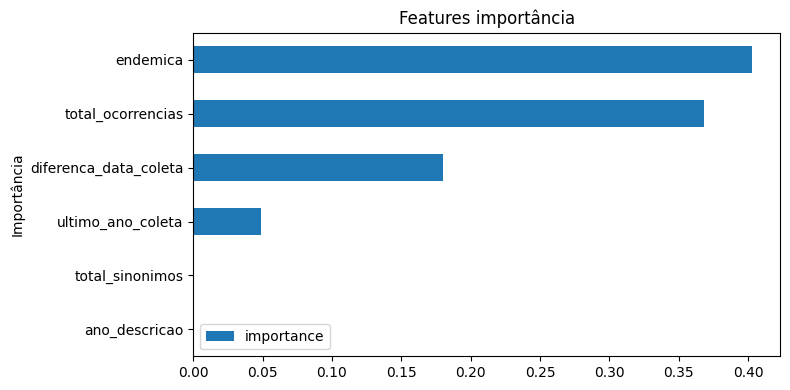

In [9]:
feature_importance.plot(kind="barh", x="feature", y="importance", figsize=(8,4))
plt.ylabel("Importância")
plt.title("Features importância")
plt.savefig("feature-importance.png")
plt.tight_layout()
plt.show()

In [19]:
len(pred_clf), len(pred_clf2)

(5, 5)

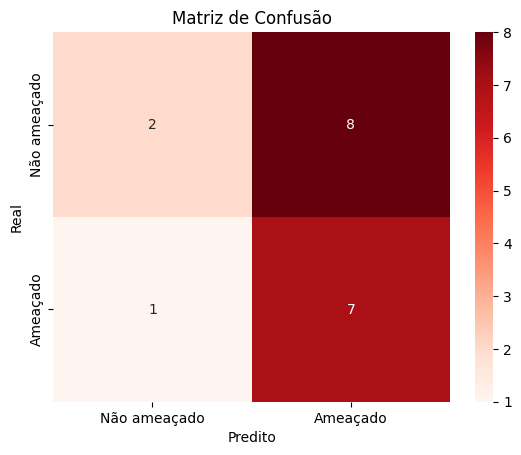

In [24]:
cm = confusion_matrix(y_test, pred_clf[2])
classes=["Não ameaçado", "Ameaçado"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=classes, yticklabels=classes)
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.savefig("confusion_matrix-rf.png")
plt.show()

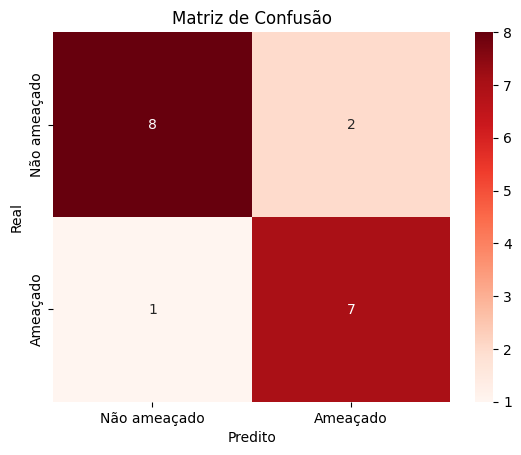

In [ ]:
cm = confusion_matrix(y_test, pred_clf2[-1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=classes, yticklabels=classes)
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.savefig("confusion_matrix-knn.png")
plt.show()